# Muon Tracking Efficiency of default tracking algorithm (with extrapolation off and electron tracking on) for a muon sample

* As of 10/6/2021:

Default tracking algorithm taking from master branch here:
https://github.com/DarkQuest-FNAL/e1039-core

Sample information:

* Vertex: (0,0,520) cm
* $p_z$: uniform 0-100 GeV
* $p_z = p_y$: uniform -5 to 5 GeV

Muon version of Patrick's study:

https://docs.google.com/presentation/d/1yjeGQh1jSf525oc5eMXiygDSqb14DJUFmnm7SfL8b1Y/edit#slide=id.geb7d800dd4_0_62

## 1. Basic functions

In [1]:
import uproot4
import numpy as np
import pandas as pd
import numba
import seaborn as sns
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
from coffea import hist
from coffea.processor import defaultdict_accumulator
import os
import copy
from scipy import stats

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

#Just to efficiently save plots
plot_dir = "plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

print("Saving plots to: ", save_path)

#Plot settings
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

## Data processing codes
def getData(fname="", treeName="Events"):
    dq_dict_ak1 = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "nTrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "GenVertex": ak.zip({
                                            "x": dq_dict_ak1["gvx"],
                                            "y": dq_dict_ak1["gvy"],
                                            "z": dq_dict_ak1["gvz"],
                                            "px": dq_dict_ak1["gpx"],
                                            "py": dq_dict_ak1["gpy"],
                                            "pz": dq_dict_ak1["gpz"]

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict_ak1["gpx_st1"],
                                            "py": dq_dict_ak1["gpy_st1"],
                                            "pz": dq_dict_ak1["gpz_st1"],
                                            "x": dq_dict_ak1["gx_st1"],
                                            "y": dq_dict_ak1["gy_st1"],
                                            "z": dq_dict_ak1["gz_st1"],
                        }),
                        "GenP_St2": ak.zip({
                                            "px": dq_dict_ak1["gpx_st2"],
                                            "py": dq_dict_ak1["gpy_st2"],
                                            "pz": dq_dict_ak1["gpz_st2"],
                                            "x": dq_dict_ak1["gx_st2"],
                                            "y": dq_dict_ak1["gy_st2"],
                                            "z": dq_dict_ak1["gz_st2"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict_ak1["track_px_st1"],
                                            "py": dq_dict_ak1["track_py_st1"],
                                            "pz": dq_dict_ak1["track_pz_st1"],
                                            "x": dq_dict_ak1["track_x_st1"],
                                            "y": dq_dict_ak1["track_y_st1"],
                                            "z": dq_dict_ak1["track_z_st1"],
                        }),
                        "reco_dimuon": ak.zip({
                                            "mass": dq_dict_ak1["dimuon_mass"],
                                            "x": dq_dict_ak1["dimuon_x_vtx"],
                                            "y": dq_dict_ak1["dimuon_y_vtx"],
                                            "z": dq_dict_ak1["dimuon_z_vtx"],
                                            "chisq": dq_dict_ak1["dimuon_chisq"],
                            
                        }),
                        "truth_dimuon":ak.zip({
                                            "mass": dq_dict_ak1['truthdimuon_mass'],
                                            "x": dq_dict_ak1['truthdimuon_x_vtx'],
                                            "y": dq_dict_ak1['truthdimuon_y_vtx'],
                                            "z": dq_dict_ak1['truthdimuon_z_vtx'],
                                            "px": dq_dict_ak1['truthdimuon_px'],
                                            "py": dq_dict_ak1['truthdimuon_py'],
                                            "pz": dq_dict_ak1['truthdimuon_pz'],
                            
                        }),
                        "fpga_trigger": ak.zip({"trigger": dq_dict_ak1["fpga_trigger"]
                            
                        }),
                       }, depth_limit=1)
    return dq_events

Saving plots to:  plot/01-12-2021


## 1. Load the data & check some basic info for the sample

In [4]:
data_path = "/work/submit/dhoang/DQ/outfiles/Muon_gun_pxy_eflagoff_extraoff_OLD_01_12_2021/*.root"

In [5]:
dq_data = getData(data_path)

In [4]:
px_cut = ak.flatten(dq_data["GenVertex"].px) > 1

In [5]:
dq_data["nTrack"].n_tracks[px_cut]

<Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='40287 * int32'>

In [7]:
plt.hist(ak.flatten(dq_data_2["GenVertex"].pz))
plt.xlabel(r" Truth $p_z$")

NameError: name 'dq_data_2' is not defined

## 2. 1D & 2D scan of px and py efficiency

In [6]:
def eff_1d(dq_data, p_cat = 'px'):
    
    if  p_cat == 'px':
        p = np.asarray(ak.flatten(dq_data["GenVertex"].px))
        x_label = r'Truth $\mu$ $p_x$ [GeV]'
    elif p_cat == 'py':
        p = np.asarray(ak.flatten(dq_data["GenVertex"].py))
        x_label = r'Truth $\mu$ $p_y$ [GeV]'
    else:
        p = np.asarray(ak.flatten(dq_data["GenVertex"].pz))
        x_label = r'Truth $\mu$ $p_z$ [GeV]'
   
    ntracks = np.asarray(dq_data["nTrack"].n_tracks)
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(p,
                                                             ntracks,
                                                             statistic='mean',
                                                             bins=20)
    
    bin_stds, _, _ = stats.binned_statistic(p,
                                            ntracks,
                                            statistic='std',
                                            bins=20)
    
    counts=[np.count_nonzero(binnumber==i) for i in np.arange(1,21,1)]
    
    plt.errorbar(bin_edges[:20],
                 bin_means,
                 bin_stds/np.sqrt(counts),
                 ls = '--',
                 fmt = 'bo',
                 ms = 7,
                 lw = 2,
                 label='binned statistic of data')
    
    plt.xlabel(x_label)
    plt.ylabel(r'Reconstruction $\epsilon$')

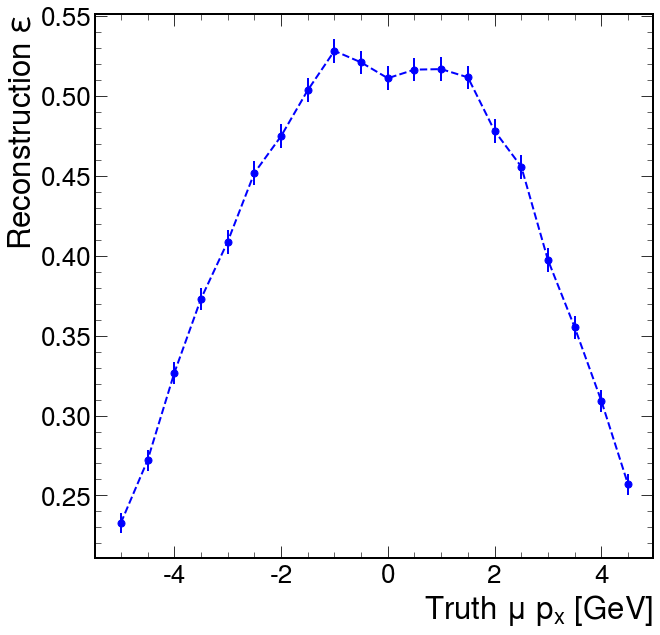

In [7]:
eff_1d(dq_data)

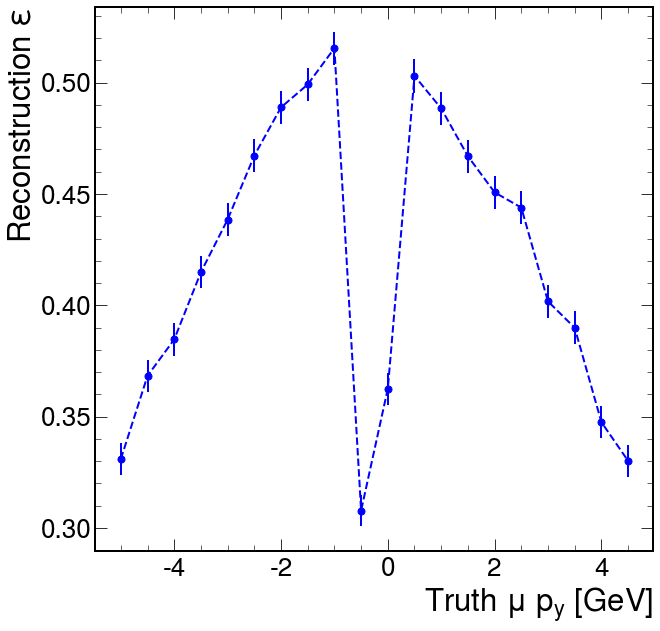

In [8]:
eff_1d(dq_data, 'py')

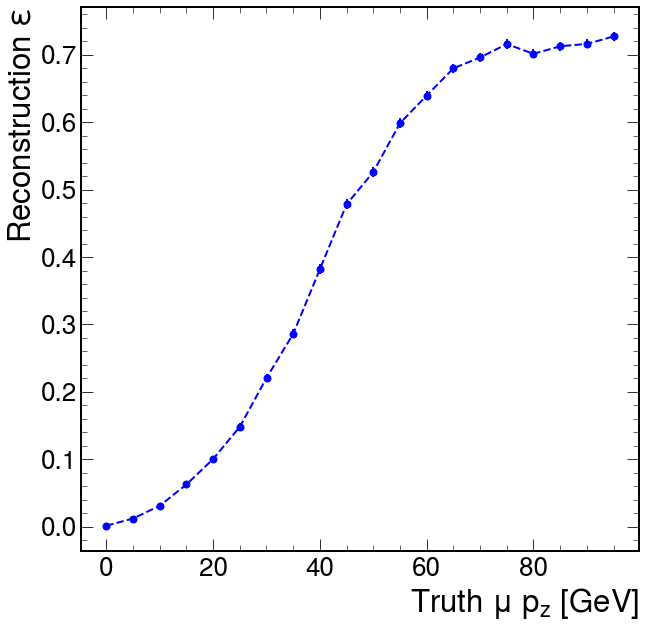

In [9]:
eff_1d(dq_data, 'pz')

-----

In [10]:
def eff_2d(dq_data, p_cat = 'px'):
    
    if  p_cat == 'px':
        p = np.asarray(ak.flatten(dq_data["GenVertex"].px))
        x_label = r'Truth $\mu$ $p_x$ [GeV]'
    elif p_cat == 'py':
        p = np.asarray(ak.flatten(dq_data["GenVertex"].py))
        x_label = r'Truth $\mu$ $p_y$ [GeV]'
        
    pzs = np.asarray(ak.flatten(dq_data["GenVertex"].pz))
    
    
    #Specify the bins
    x_bins = np.linspace(-5, 5, 20)
    y_bins = np.linspace(0, 100, 20)
    

   
    ntracks = np.asarray(dq_data["nTrack"].n_tracks)
    
    bin_means = stats.binned_statistic_2d(np.array(p),
                                          np.array(pzs),
                                          np.array(ntracks),
                                          statistic='mean',
                                          bins=[x_bins, y_bins])
    
    im = plt.imshow(np.flip(bin_means.statistic.T,0), extent=(-5, 5, 0, 100), aspect='auto')
    
    plt.colorbar(im, label=r'Reco $\epsilon$')
    plt.xlabel(x_label)
    plt.ylabel(r'Truth $\mu$ $p_z$ [GeV]')

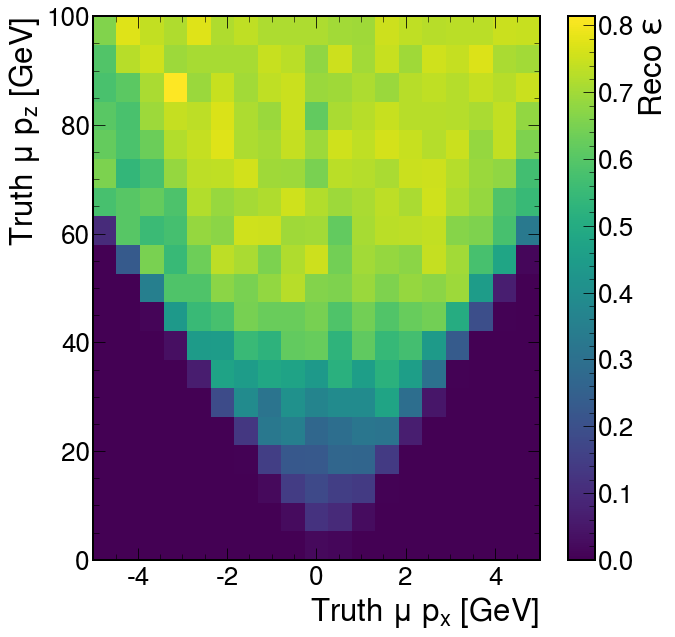

In [11]:
eff_2d(dq_data)

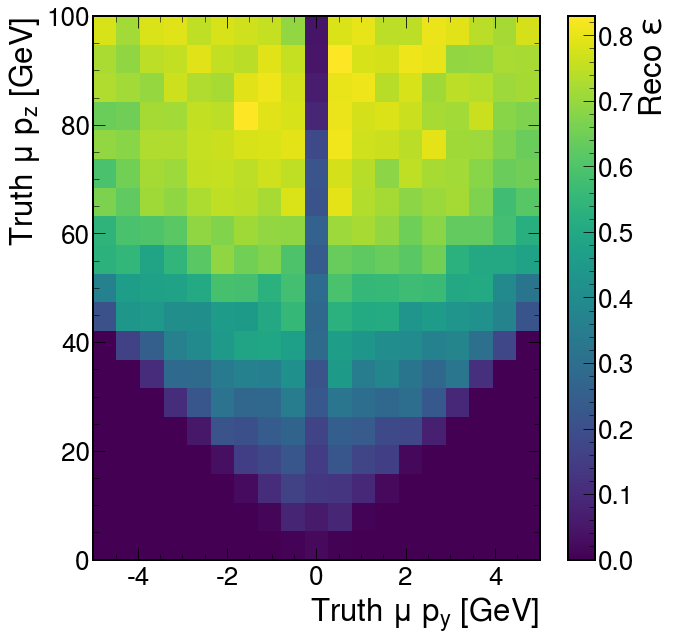

In [12]:
eff_2d(dq_data, 'py')

--------

# Sample 2

* z = 520cm
* x, y uniform -100cm to 100cm
* $p_z$ = 0-100 GeV
* $p_x$ = $p_y$ = -0.01 to 0.01 GeV

In [11]:
data_path_2 = "/data/t3home000/dhoang/DQ/outfiles/Muon_gun_x_y_eflag_extraoff_OLD_01_11_2021/*root"

In [4]:
dq_data_2 = getData(data_path_2)

## Sample 2 -- 1D efficiency

In [5]:
def eff_1d_vtx(dq_data, vtx_cat = 'x'):
    
    if  vtx_cat == 'x':
        pos = np.asarray(ak.flatten(dq_data["GenVertex"].x))
        x_label = r'Truth vertex x [cm]'
    elif vtx_cat == 'y':
        pos = np.asarray(ak.flatten(dq_data["GenVertex"].y))
        x_label = r'Truth vertex y [cm]'
   
    ntracks = np.asarray(dq_data["nTrack"].n_tracks)
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(pos,
                                                             ntracks,
                                                             statistic='mean',
                                                             bins=20)
    
    bin_stds, _, _ = stats.binned_statistic(pos,
                                            ntracks,
                                            statistic='std',
                                            bins=20)
    
    counts=[np.count_nonzero(binnumber==i) for i in np.arange(1,21,1)]
    
    plt.errorbar(bin_edges[:20],
                 bin_means,
                 bin_stds/np.sqrt(counts),
                 ls = '--',
                 fmt = 'bo',
                 ms = 7,
                 lw = 2,
                 label='binned statistic of data')
    
    plt.xlabel(x_label)
    plt.ylabel(r'Reconstruction $\epsilon$')

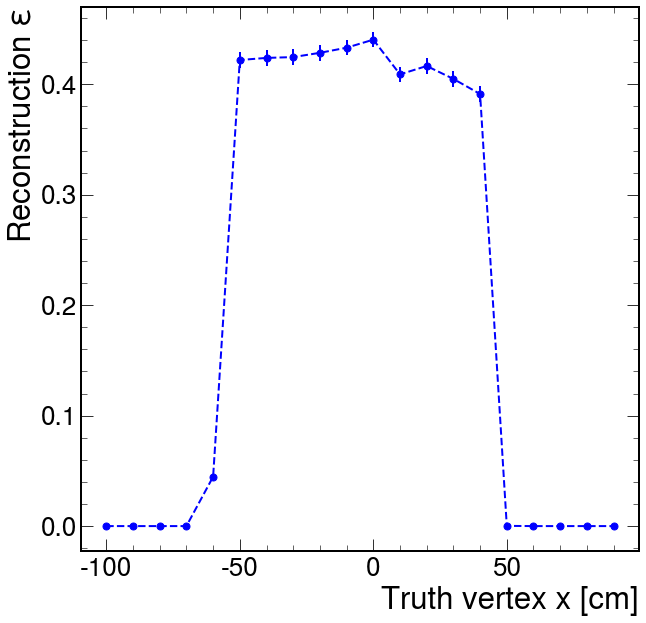

In [6]:
eff_1d_vtx(dq_data_2)

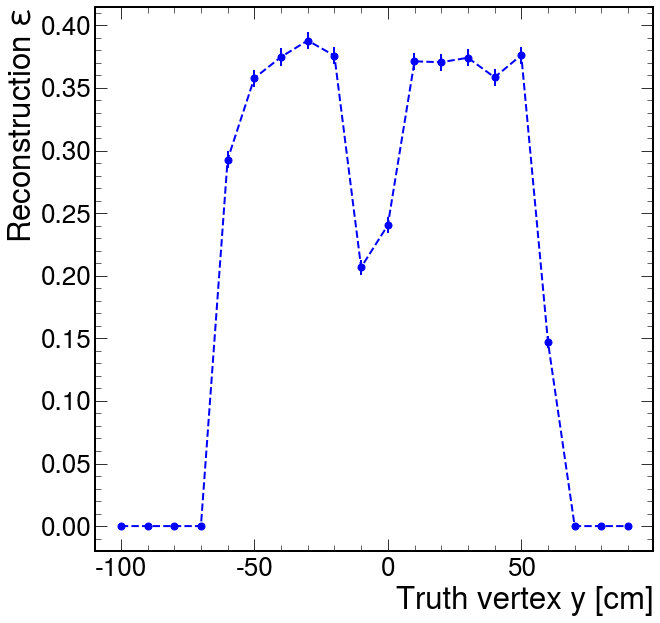

In [7]:
eff_1d_vtx(dq_data_2, 'y')

-----

# Sample 3

* x=y=0
* z = 450cm to 750 cm
* $p_z$: 0-100 GeV
* $p_x, p_y$: -1 to 1 GeV

In [14]:
data_path_3 = "/data/t3home000/dhoang/DQ/outfiles/Muon_gun_z_eflag_extraoff_02_11_2021/*root"

In [15]:
dq_data_3 = getData(data_path_3)

In [16]:
def eff_1d_vtx_z(dq_data):
    
    pos = np.asarray(ak.flatten(dq_data["GenVertex"].z))
    x_label = r'Truth vertex z [cm]'
   
    ntracks = np.asarray(dq_data["nTrack"].n_tracks)
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(pos,
                                                             ntracks,
                                                             statistic='mean',
                                                             bins=20)
    
    bin_stds, _, _ = stats.binned_statistic(pos,
                                            ntracks,
                                            statistic='std',
                                            bins=20)
    
    counts=[np.count_nonzero(binnumber==i) for i in np.arange(1,21,1)]
    
    plt.errorbar(bin_edges[:20],
                 bin_means,
                 bin_stds/np.sqrt(counts),
                 ls = '--',
                 fmt = 'bo',
                 ms = 7,
                 lw = 2,
                 label='binned statistic of data')
    
    plt.xlabel(x_label)
    plt.ylabel(r'Reconstruction $\epsilon$')

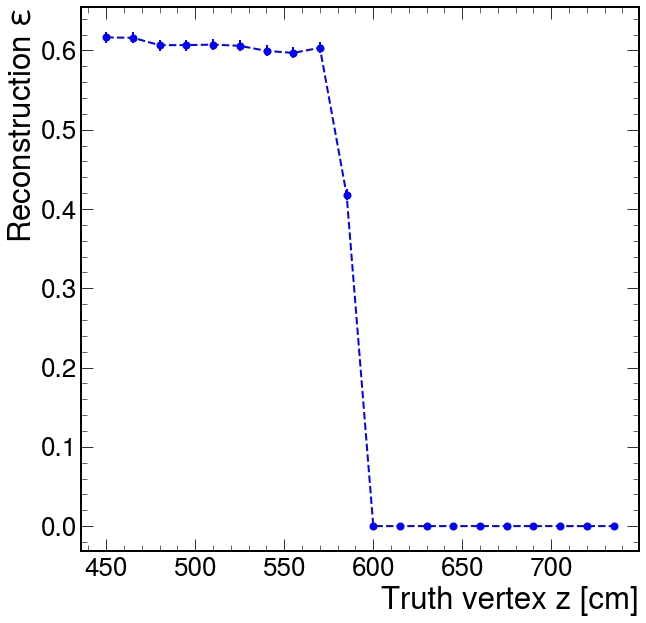

In [17]:
eff_1d_vtx_z(dq_data_3)